In [7]:
import itertools as it
import math
from collections import Counter
from sympy import Matrix, Rational, eye, sqrt, symbols, expand, re, im, N
from functools import lru_cache
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from activation_funcs import *

In [8]:
# ============================================================
# 1. Combinatorial helpers (fast class enumeration)
# ============================================================

def integer_partitions(n):
    """Generate integer partitions of n in nonincreasing order."""
    def gen(n, max_part):
        if n == 0:
            yield ()
            return
        for x in range(min(n, max_part), 0, -1):
            for rest in gen(n - x, x):
                yield (x,) + rest
    return list(gen(n, n))

def class_size_from_type(n, part):
    """
    Class size = n! / (Π_i (m_i! * i^{m_i}))
    where m_i = multiplicity of i in part.
    """
    mult = Counter(part)
    denom = 1
    for i, m in mult.items():
        denom *= math.factorial(m) * (i**m)
    return math.factorial(n) // denom

def conjugacy_class_reps(n):
    """
    Return [{type:part, size:int}] without enumerating permutations.
    Representatives are *not* concrete perms (we'll act combinatorially).
    """
    return [{"type": part, "size": class_size_from_type(n, part)} for part in integer_partitions(n)]

def safe_real_value(x):
    """Try to get a numeric real value from possibly complex/symbolic x."""
    try:
        val = complex(N(x))
    except Exception:
        return None
    if abs(val.imag) < 1e-8:
        return float(val.real)
    return None

# ============================================================
# 2. k-subset permutation representation
# ============================================================

def k_subsets(n, k):
    return [tuple(c) for c in it.combinations(range(n), k)]

def perm_matrix_from_cycles(n, k, cycles):
    """
    Build ρ(σ) given its cycle decomposition 'cycles' = [(a,b,c,...), ...].
    We'll compute the induced permutation on k-subsets directly.
    """
    Xk = k_subsets(n, k)
    idx = {A:i for i,A in enumerate(Xk)}
    m = len(Xk)
    M = [[0]*m for _ in range(m)]

    # build permutation map
    perm_map = list(range(n))
    for cyc in cycles:
        cyc = list(cyc)
        L = len(cyc)
        for t in range(L):
            perm_map[cyc[t]] = cyc[(t+1)%L]

    for j,A in enumerate(Xk):
        B = tuple(sorted(perm_map[a] for a in A))
        i = idx[B]
        M[i][j] = 1
    return Matrix(M)

def canonical_cycles_from_type(part):
    """
    Construct one canonical cycle decomposition for a given cycle-type partition.
    Example: (3,2) -> [(0,1,2), (3,4)]
    """
    cycles = []
    current = 0
    for L in part:
        cyc = tuple(range(current, current+L))
        cycles.append(cyc)
        current += L
    return cycles

# ============================================================
# 3. Character evaluation (symbolic, cached)
# ============================================================

@lru_cache(None)
def chi_two_row(n, i, cycle_type_part):
    """
    χ^{(n-i,i)}(σ) = π_{n,i}(σ) - π_{n,i-1}(σ)
    where π_{n,k}(σ) = [x^k] ∏_{m>=1}(1+x^m)^{a_m}
    """
    x = symbols('x')
    c = Counter(cycle_type_part)
    a = {m: c.get(m,0) for m in range(1, n+1)}
    P = 1
    for m, am in a.items():
        if am:
            P *= (1 + x**m)**am
    P = expand(P)
    def coeff(k): return P.coeff(x, k)
    return Rational(1) if i==0 else coeff(i) - coeff(i-1)

def dim_two_row(n, i):
    return math.comb(n, i) - (math.comb(n, i-1) if i>0 else 0)

# ============================================================
# 4. Central idempotents via class sums (optimized)
# ============================================================

def projectors_two_row_fast(n, k):
    """
    Faster version using class reps and their combinatorial sizes.
    """
    basis = k_subsets(n, k)
    m = len(basis)
    proj, Qblocks = {}, {}
    classes = conjugacy_class_reps(n)
    rho_cache = {}

    for C in classes:
        cycles = canonical_cycles_from_type(C["type"])
        rho_cache[tuple(C["type"])] = perm_matrix_from_cycles(n, k, cycles)

    for i in range(0, k+1):
        dimL = dim_two_row(n, i)
        M = Matrix.zeros(m)
        for C in classes:
            mu = C["type"]
            chi_val = chi_two_row(n, i, mu)
            S_C = rho_cache[tuple(mu)]
            M += C["size"] * chi_val * S_C
        p = Rational(dimL, math.factorial(n)) * M
        p = (p + p.T)/2
        proj[i] = p

        evects = p.eigenvects()
        eig1 = [v for (val, mult, vecs) in evects if val == 1 for v in vecs]

        if len(eig1) < dimL:
            for (val, mult, vecs) in evects:
                val_real = safe_real_value(val)
                if val_real is not None and abs(val_real - 1.0) < 1e-8:
                    eig1.extend(vecs)

        cols = [Matrix(v) for v in eig1[:dimL]]

        # simple exact orthonormalisation
        ortho_cols = []
        for v in cols:
            for u in ortho_cols:
                v -= (u.dot(v)/u.dot(u))*u
            v /= sqrt(v.dot(v))
            ortho_cols.append(v)
        Qblocks[i] = Matrix.hstack(*ortho_cols)

    return proj, Qblocks, basis

# ============================================================
# 5. Fourier utilities (unchanged)
# ============================================================

def assemble_Q(Qblocks):
    return Matrix.hstack(*[Qblocks[i] for i in sorted(Qblocks.keys())])

# ============================================================
# 6. Interaction graph (same logic as before)
# ============================================================

def build_decompositions(n, K_max):
    return {k: {"Qblocks": projectors_two_row_fast(n,k)[1]} for k in range(K_max+1)}

def canonical_irrep_blocks(decomps):
    irreps = {}
    for k, data in decomps.items():
        for i, Qki in data["Qblocks"].items():
            if i not in irreps:
                irreps[i] = {"Q": Qki, "k_source": k,
                             "dim": Qki.shape[1], "ambient_dim": Qki.shape[0]}
    return irreps

from itertools import combinations

def test_edge_activation(irreps, i, j, activation_fn, tol=1e-8):
    """
    Deterministic test for whether activation_fn creates a nonzero component
    in irrep j starting from irrep i.

    activation_fn: scalar -> scalar, applied elementwise.
    Returns True if there exists a *basis vector or a sum of two basis vectors*
    of L_i whose activated image has a nonzero projection onto L_j.
    """
    Qi = irreps[i]["Q"]  # ambient_dim x dim_i
    Qj = irreps[j]["Q"]  # ambient_dim x dim_j

    # they must live in the same ambient representation space (same k-source)
    ambient_dim_i, ambient_dim_j = Qi.shape[0], Qj.shape[0]
    if ambient_dim_i != ambient_dim_j:
        return False

    dim_i = Qi.shape[1]

    # --- helper: project after activation ---
    def project_and_check(v):
        """Apply activation and check projection onto L_j."""
        v_act = v.applyfunc(lambda z: activation_fn(float(z)))
        coeffs_j = Qj.T * v_act
        for c in coeffs_j:
            if abs(float(c)) > tol:
                return True
        return False

    # --- 1. test each individual basis vector (pure directions) ---
    for r in range(dim_i):
        v = Qi[:, r]
        if project_and_check(v):
            return True

    # --- 2. test pairwise sums of distinct basis vectors (superpositions) ---
    # this captures nonlinear cross-direction effects
    for a, b in combinations(range(dim_i), 2):
        v_sum = Qi[:, a] + Qi[:, b]
        if project_and_check(v_sum):
            return True

    # nothing leaked into L_j
    return False



def build_simple_irrep_interaction_graph(n, activation_fn, K_max=None, tol=1e-8):
    """
    n: size of S_n
    K_max: consider V_{n,k} for k = 0..K_max
    activation_fn: scalar -> scalar
    """
    if K_max is None:
        K_max = n

    # 1. build decompositions for each k
    decomps = {}
    for k in range(K_max+1):
        _, Qblocks, _ = projectors_two_row_fast(n,k)
        decomps[k] = Qblocks

    # 2. pick canonical irrep data
    irreps = {}
    for k, Qblocks in decomps.items():
        for i, Qi in Qblocks.items():
            if i not in irreps:
                irreps[i] = {
                    "Q": Qi,
                    "k_source": k,
                    "dim": Qi.shape[1],
                    "ambient_dim": Qi.shape[0],
                }

    # 3. group irreps by which carrier space they came from
    by_k = {}
    for i, meta in irreps.items():
        ksrc = meta["k_source"]
        by_k.setdefault(ksrc, []).append(i)

    # 4. build directed graph
    import networkx as nx
    G = nx.DiGraph()
    for i in irreps.keys():
        G.add_node(i)

    for ksrc, irr_list in by_k.items():
        for a in irr_list:
            for b in irr_list:
                if test_edge_activation(irreps, a, b, activation_fn, tol=tol):
                    G.add_edge(a, b, carrier_k=ksrc)

    return G, irreps


def visualize_irrep_graph(G, title="Irrep interaction graph"):
    pos = nx.spring_layout(G, seed=42)
    labels = {i: f"(n-{i},{i})" for i in G.nodes()}
    plt.figure(figsize=(6,6))
    nx.draw_networkx_nodes(G, pos, node_color='lightgreen', node_size=1200)
    nx.draw_networkx_labels(G, pos, labels, font_size=10)
    nx.draw_networkx_edges(G, pos, arrows=True, arrowsize=20, width=2)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u,v):f"k={G[u][v]['carrier_k']}" for u,v in G.edges()},
                                 font_color='red', font_size=8)
    plt.title(title)
    plt.axis('off')
    plt.show()



Edges: [(0, 0)]


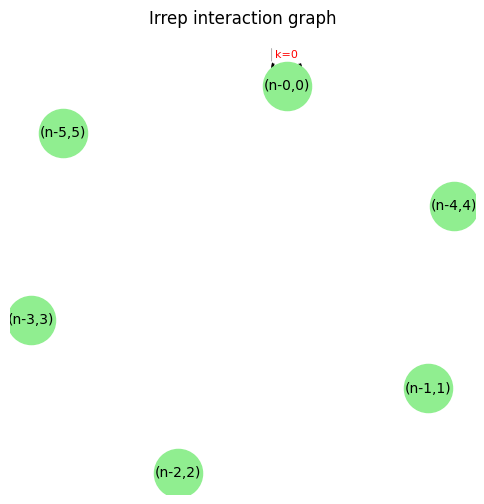

In [9]:
n = 5

activation_fn = lambda x: x**2
G, irreps = build_simple_irrep_interaction_graph(n=n, activation_fn=activation_fn, tol=1e-6)
print("Edges:", G.edges())
visualize_irrep_graph(G)

# Higher-Order Space

In [30]:
# ===========================================================
# Example: interaction graph for S_5 acting on 2-subsets
# ===========================================================
import itertools as it, math, networkx as nx, matplotlib.pyplot as plt
from collections import Counter
from sympy import Matrix, Rational, eye, sqrt, symbols, expand

# ===========================================================
# Helper: combinatorics
# ===========================================================

def k_subsets(n, k):
    return [tuple(c) for c in it.combinations(range(n), k)]

def canonical_pair(a,b):
    return tuple(sorted([a,b]))

def quadratic_basis(n, k):
    Xk = k_subsets(n, k)
    pairs = []
    for i,A in enumerate(Xk):
        for j,B in enumerate(Xk):
            if j < i: continue
            pairs.append(canonical_pair(A,B))
    pairs = list(dict.fromkeys(pairs))
    index = {pairs[t]:t for t in range(len(pairs))}
    return pairs, index

def perm_on_subset(sigma, A):
    return tuple(sorted(sigma[a] for a in A))

def quadratic_perm_matrix(n, k, sigma):
    qbasis, qindex = quadratic_basis(n, k)
    m2 = len(qbasis)
    M = [[0]*m2 for _ in range(m2)]
    for j,(A,B) in enumerate(qbasis):
        A2,B2 = perm_on_subset(sigma,A), perm_on_subset(sigma,B)
        tgt = canonical_pair(A2,B2)
        i = qindex[tgt]
        M[i][j] = 1
    return Matrix(M)

def perm_matrix(n, k, sigma):
    Xk = k_subsets(n, k)
    idx = {A:i for i,A in enumerate(Xk)}
    m = len(Xk)
    M = [[0]*m for _ in range(m)]
    for j,A in enumerate(Xk):
        B = tuple(sorted(sigma[a] for a in A))
        i = idx[B]
        M[i][j] = 1
    return Matrix(M)

# ===========================================================
# Character machinery for S_n (two-row partitions)
# ===========================================================

def integer_partitions(n):
    def gen(n,maxp):
        if n==0: yield (); return
        for a in range(min(n,maxp),0,-1):
            for rest in gen(n-a,a): yield (a,)+rest
    return list(gen(n,n))

def class_size_from_type(n,part):
    mult=Counter(part); denom=1
    for l,m in mult.items(): denom*=math.factorial(m)*(l**m)
    return math.factorial(n)//denom

def conjugacy_class_data(n):
    classes=[]
    used=set()
    for part in integer_partitions(n):
        if part in used: continue
        used.add(part)
        perm=list(range(n)); idx=0
        for L in part:
            cyc=list(range(idx,idx+L))
            for t in range(L-1): perm[cyc[t]]=cyc[t+1]
            perm[cyc[-1]]=cyc[0]; idx+=L
        classes.append({'type':part,'size':class_size_from_type(n,part),'rep':tuple(perm)})
    return classes

def chi_two_row(n,i,cycle_type_part):
    x=symbols('x'); c=Counter(cycle_type_part)
    P=1
    for m,am in c.items():
        P*=(1+x**m)**am
    P=expand(P)
    def coeff(k): return P.coeff(x,k)
    if i==0: return Rational(1)
    return coeff(i)-coeff(i-1)

def dim_two_row(n,i):
    return math.comb(n,i)-(math.comb(n,i-1) if i>0 else 0)

def gram_schmidt(vectors):
    ortho=[]
    for v in vectors:
        w=v
        for u in ortho: w=w-(u.dot(w)/u.dot(u))*u
        if w.norm()!=0:
            w=w/sqrt(w.dot(w))
            ortho.append(w)
    return ortho

# ===========================================================
# Projectors for two-row irreps
# ===========================================================

def projectors_two_row_general(n, k, perm_matrix_fn):
    """
    Decompose the given representation (defined by perm_matrix_fn)
    into the two-row irreps S^{(n-i,i)} for i=0..k.
    Works for either V_{n,k} (linear) or Sym^2(V_{n,k}) (quadratic).
    """
    classes = conjugacy_class_data(n)
    # build ρ(rep) using the given perm_matrix_fn
    sample = perm_matrix_fn(n, k, classes[0]['rep'])
    m = sample.shape[0]  # ambient dimension

    # precompute ρ(g) for each class representative
    rho_class = {}
    for C in classes:
        sigma = C['rep']
        rho_class[tuple(C['type'])] = perm_matrix_fn(n, k, sigma)

    proj, Qblocks = {}, {}
    for i in range(0, k+1):
        dimL = dim_two_row(n, i)
        M = Matrix.zeros(m)
        for C in classes:
            mu = C['type']
            chi_val = chi_two_row(n, i, mu)
            M += C['size'] * chi_val * rho_class[tuple(mu)]
        p = Rational(dimL, math.factorial(n)) * M
        p = (p + p.T) / 2
        ev = p.eigenvects()
        eig1 = [v for (val, mult, vecs) in ev if val == 1 for v in vecs]
        if len(eig1) < dimL:
            from sympy import N
            def is_one(val):
                try:
                    cval = complex(N(val))
                    return abs(cval.real - 1) < 1e-8 and abs(cval.imag) < 1e-8
                except: return False
            for (val, mult, vecs) in ev:
                if is_one(val): eig1.extend(vecs)
        cols = [Matrix(v) for v in eig1[:dimL]]
        ortho_cols = gram_schmidt(cols)
        if ortho_cols:
            Qblocks[i] = Matrix.hstack(*ortho_cols)
            proj[i] = p
    return proj, Qblocks


# ===========================================================
# Lifted quadratic interaction test
# ===========================================================

def lift_to_quadratic_feature(v,n,k):
    Xk=k_subsets(n,k)
    idx={A:i for i,A in enumerate(Xk)}
    qbasis,_=quadratic_basis(n,k)
    F=[0]*len(qbasis)
    for t,(A,B) in enumerate(qbasis):
        F[t]=float(v[idx[A]])*float(v[idx[B]])
    return Matrix(F)

def test_edge_activation_quadratic(Qi,Qj2,activation_fn,n,k,tol=1e-8):
    cols=[Qi[:,r] for r in range(Qi.shape[1])]
    from itertools import combinations
    candidates=cols[:]
    for a,b in combinations(range(len(cols)),2):
        candidates.append(cols[a]+cols[b])
    for v in candidates:
        v_act=v.applyfunc(lambda z: activation_fn(float(z)))
        F=lift_to_quadratic_feature(v_act,n,k)
        coeffs=Qj2.T*F
        for c in coeffs:
            if abs(float(c))>tol:
                return True
    return False

# ===========================================================
# Build interaction graph lin→quad
# ===========================================================

def build_interaction_graph_quadratic(n,k,activation_fn):
    proj_lin, Q_lin = projectors_two_row_general(n, k, perm_matrix)
    proj_quad, Q_quad = projectors_two_row_general(n, k, quadratic_perm_matrix)
    G=nx.DiGraph()
    for i in Q_lin.keys(): G.add_node(("lin",i))
    for j in Q_quad.keys(): G.add_node(("quad",j))
    for i,Qi in Q_lin.items():
        for j,Qj2 in Q_quad.items():
            if test_edge_activation_quadratic(Qi,Qj2,activation_fn,n,k):
                G.add_edge(("lin",i),("quad",j))
    return G

def visualize(G):
    pos=nx.spring_layout(G,seed=2)
    labels={node: f"{node[0]} {node[1]}" for node in G.nodes()}
    plt.figure(figsize=(6,6))
    nx.draw(G,pos,with_labels=True,labels=labels,
            node_color='lightblue',node_size=1200,
            arrows=True,arrowsize=20,width=2)
    # plt.title("Irrep interaction graph (S5, k=2)")
    plt.axis("off"); plt.show()

Edges: [(('lin', 0), ('quad', 0))]


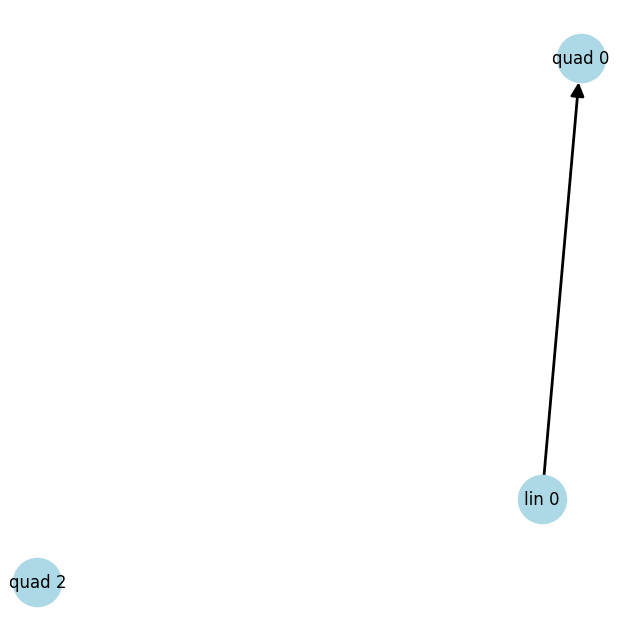

In [31]:
n,k=4,3
activation_fn= RELU

G=build_interaction_graph_quadratic(n,k,activation_fn)
print("Edges:",list(G.edges()))
visualize(G)